# Информационные ресурсы Беларуси
Данные скачены __2021-08-18__ из [Государственного регистра информационных ресурсов](http://грис.бел/app/registerIR) (далее - ГРИР) через [инструменты](https://developer.mozilla.org/ru/docs/Tools/Tools_Toolbox) разработчика браузера __*Mozilla Firefox*__ и сохранены в формате `.xlsx`.

В этом проекте __*Jupiter*__ представлены результаты анализа скаченых данных.

## 1. Подготовка к анализу

### Импортируем необходимые для анализа библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

### Загружаем данные в проект 

In [2]:
file = 'db/IR_list.xlsx' # файл представляет собой таблицу из столбцов (параметры) и строк (информационные ресурсы)
date_parser = lambda x: datetime.strptime(x, '%d.%m.%Y') # определяем формат даты
data = pd.read_excel(file, 
                     header=0, # название столбцов в первой строке (заметка: в Python отсчет начинается с 0, а не 1)
                     parse_dates=['Дата регистрации', 'Дата исключения', 'Дата актуализации'], # содержат дату
                     date_parser=date_parser, 
                     na_values='') # пустые поля обозначаем 'NA' для Python

### Проверяем структуру файла

In [3]:
rows = data.shape[0]
columns = data.shape[1]
print(f'Количество строк: {rows}\nКоличество столбцов: {columns}\n')

Количество строк: 26340
Количество столбцов: 14



### Выводим названия столбцов

In [4]:
data_cols = data.columns.tolist()
print(*data_cols, sep = '\n')

Номер свидетельства
Полное наименование ИР
Краткое наименование ИР
Дата регистрации
Владелец
УНП владельца
Разработчик
УНП разработчика
Дата актуализации
Дата исключения
Рубрика
Тематика
Тип
Содержательная характеристика


## Исключаем ненужные для анализа столбцы
Для целей анализа не пригодятся следующие данные: 
* номер свидетельства - дополнительной информации не несет
* краткие наименование информационных ресурсов - дублируют информацию из полного наименования
* УНП владельца и разработчика - малоинформативны
* дата актуализации - малоинформативно потому как информационный ресурс не добавляется и не удаляется из регистра

In [5]:
data.drop(columns=['Номер свидетельства', 
                   'Краткое наименование ИР', 
                   'УНП владельца', 
                   'УНП разработчика',
                   'Дата актуализации'], 
          inplace=True)

### Проверяем таблицу на полноту данных

In [6]:
data.isnull().sum()

Полное наименование ИР               0
Дата регистрации                     0
Владелец                             2
Разработчик                        562
Дата исключения                  25242
Рубрика                              0
Тематика                             0
Тип                                  0
Содержательная характеристика        7
dtype: int64

*__Итак__, данные не полные:*
* сведения о владельце не указаны 2 раза
* сведения о разработчике не указаны 562 раза, возможно потому как разработчик и владелец представлены в одном лице
* сведения о содержательной характеристике не представлены 7 раз
* отсутствие сведений о дате исключения говорит о том, что информационная система продолжает функционировать

### Переименовываем столбцы в необходимые для анализа значения

In [7]:
df = data.rename(columns={'Полное наименование ИР':'name', # создаем копию базы данных 'data'  
                'Дата регистрации':'reg_date',             # с новыми названиями столбцов - 'df'
                'Владелец':'holder', 
                'Разработчик':'developer', 
                'Дата исключения':'excl_date',
                'Рубрика':'cat', 
                'Тематика':'topic',  
                'Тип':'type_ir',
                'Содержательная характеристика':'descript'})

### Выводим строки без сведений о разработчике, собственнике, структуре, размере финансирования и характере решаемых задач

In [8]:
filt = (df.holder.isnull()) | (df.descript.isnull())

df.loc[filt, ['name', 'holder', 'descript']]

,name,holder,descript
6005,Официальный сайт государственного учреждения о...,"ГУО ""Ясли-сад №418 г.Минска""",NaN
7082,Страноведение на первом иностранном языке: эле...,"УО ""БГЭУ""",NaN
7493,"Электронный учебно-методический комплекс ""Пато...",Гродненский медуниверситет,NaN
7498,Электронный учебно-методический комплекс по уч...,Академия управления,NaN
8163,Национальная экономика Беларуси: электронный у...,"УО ""БГЭУ""",NaN
11401,Официальный сайт государственного учреждения о...,"ГУО ""Ясли-сад №454 г. Минска""",NaN
14950,"Государственное учреждение ""Сморгонский районн...","ГУ ""Сморгонский РУМК""",NaN
16696,Официальный сайт государственного учреждения о...,NaN,На сайте размещены сведения об учреждении обра...
21603,"Официальный сайт маркетингового агентства ""Nin...",NaN,На сайте размещены сведения о маркетинговом аг...


### Дополняем данные владельцах
*учитывая, что отсутствуют данные о владельцах официальных сайтов, то дополним эти сведения из названий*

In [9]:
df.iloc[16696, 2] = 'ГУО "Ясли – сад № 462 г.Минска"'
df.iloc[21603, 2] = 'маркетинговое агентство "NinjaPromo"'

__Обращаем внимание__, что строки колонки "Содержательная характеристика" без данных (`NaN`) при анализе не используются, что необходимо учитывать при интерпретации результатов 

### Количество действующих информационных систем

In [10]:
total_ir = df.shape[0]
excl_n = df.excl_date.count()
excl_share = excl_n / df.shape[0] * 100
current_ir = total_ir - excl_n
current_ir_share = (total_ir - excl_n) / df.shape[0] * 100
print("""Общее количество информационных систем - {}, из них:
действующих - {}, что составляет {:4.2f}%
исключенных - {}, что составляет {:4.2f}%""".format(total_ir, current_ir, current_ir_share, excl_n, excl_share))

Общее количество информационных систем - 26340, из них:
действующих - 25242, что составляет 95.83%
исключенных - 1098, что составляет 4.17%


## 2. Динамика регистрации в ГРИР

### Динамика регистрации ГРИР по годам

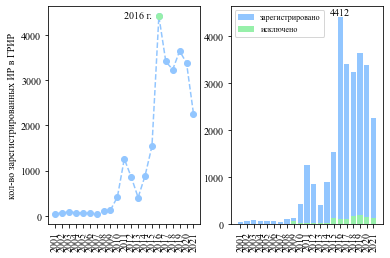

In [11]:
y_reg = df.groupby(df.reg_date.dt.year).name.count()
y_excl = df.groupby(df.excl_date.dt.year).name.count()
plt.style.use('seaborn-pastel')
plt.rcParams['font.family'] = 'Times New Roman'
fig, ax = plt.subplots(1, 2)
ax[0].plot(y_reg.index, y_reg.values, marker='o', linestyle="--")
ax[0].plot(y_reg.idxmax(), y_reg.max(), marker='o')
ax[0].set_ylabel("кол-во зарегистрированных ИР в ГРИР")
ax[0].set_xticks(y_reg.index)
ax[0].tick_params(axis='x', labelrotation=90)
ax[0].text(x=2011, y=y_reg.max()-50, s=f'2016 г.')
ax[1].bar(y_reg.index, y_reg.values)
ax[1].bar(y_excl.index, y_excl.values)
ax[1].set_xticks(y_reg.index)
ax[1].text(x=y_reg.idxmax()-1.5, y=y_reg.max()+40, s=f'4412')
ax[1].tick_params(axis='x', labelrotation=90)
ax[1].legend(['зарегистрировано', 'исключено'], fontsize=8)
plt.savefig('pics/pr1-din_double.png', dpi=600)
plt.show()

## 2. Характеристика ИР

### Рубрики ИР

In [12]:
cats = df.cat.value_counts().to_frame()
cats

,cat
Образование. Педагогика,15741
Медицина. Здравоохранение и социальные услуги. Ветеринария,1382
Экономика. Экономические науки,1129
Военное дело,900
Языкознание,663
...,...
Выставки. Международная деятельность,2
Домоводство. Домашнее хозяйство,1
Комплексные проблемы общественных наук,1
Деятельность экстерриториальных организаций,1


In [13]:
filt_c = (df.cat == 'Государственное управление') |\
         (df.cat == 'Государство и право. Юридические науки')

filt_ped = (df.cat == 'Образование. Педагогика')

percent_c = df.loc[filt_c].shape[0]/df.shape[0]*100

percent_ped = df.loc[filt_ped].shape[0]/df.shape[0]*100

print('Количество ИР в рубриках, связанных с государственным управлением:', 
      df.loc[filt_c].shape[0],
     '\nЭто', round(percent_c, 2), 'процента об общего числа ИР')
print('\nКоличество ИР в рубрике "Образование. Педагогика":', 
      df.loc[filt_ped].shape[0],
     '\nЭто', round(percent_ped, 2), 'процента об общего числа ИР')

Количество ИР в рубриках, связанных с государственным управлением: 744 
Это 2.82 процента об общего числа ИР

Количество ИР в рубрике "Образование. Педагогика": 15741 
Это 59.76 процента об общего числа ИР


### Распределение ИР в зависимости от тематики

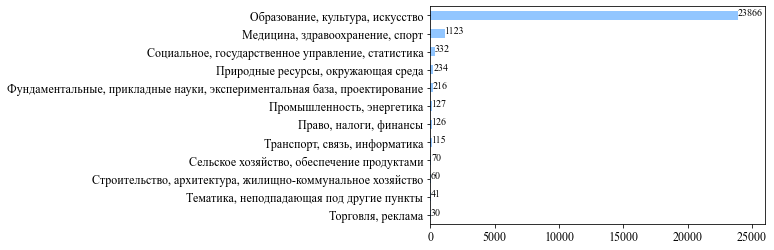

In [14]:
topics_count = df.topic.value_counts(ascending=True)
topics_count.plot(kind='barh', legend=False, xlabel='', fontsize=12)
plt.rcParams['font.family'] = 'Times New Roman'
for count, row in enumerate(topics_count):
    plt.text(y=count, x=int(row), s=f"{int(row)}")
plt.xlim(0, 26000)
plt.savefig('pics/pr2-topics.png', dpi=600, bbox_inches='tight')
plt.show()

### Распределение ИР в зависимости от тематики (без "Образование, культура, искусство")

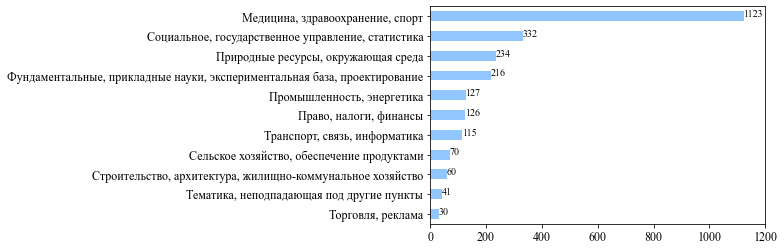

In [15]:
topics_count_noed = df[df.topic != 'Образование, культура, искусство'].topic.value_counts(ascending=True)
topics_count_noed.plot(kind='barh', legend=False, xlabel='', fontsize=12)
plt.rcParams['font.family'] = 'Times New Roman'
for count, row in enumerate(topics_count_noed):
    plt.text(y=count, x=int(row), s=f"{int(row)}")
plt.xlim(0, 1200)
plt.show()

### Типы ИР

In [16]:
types = df.type_ir.value_counts().to_frame()
print('Количество типов ИР:', types.shape[0])

Количество типов ИР: 28


### Типы ИР с количество более 100 записей

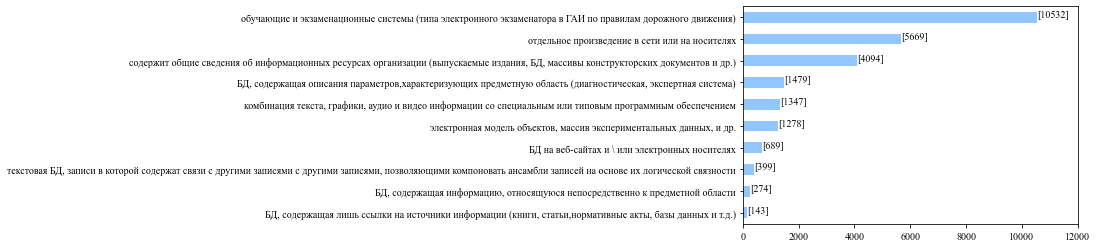

In [17]:
main_types = types[types.values > 100].sort_values(by='type_ir')
main_types.plot(kind='barh', legend=False)
for index, value in enumerate(main_types.values):
    plt.text(y=index, x=value, s=f"{value}")
plt.xlim(0, 12000)
plt.show()

### Особое внимание обратим на тип "порталы и сайты"

In [18]:
types.loc[['порталы и сайты тематической направленности'], 'type_ir']

порталы и сайты тематической направленности    73
Name: type_ir, dtype: int64

### Количество ИР со словами "сайт" или "портал" в названиях

In [19]:
total_web = df[df.name.str.contains('сайт|Сайт|портал|Портал', regex=True)]
total_web.shape[0]

4129

### Количество ИР со словами "мобильное" в названиях

In [20]:
total_mob = df[df.name.str.contains('Приложение|приложение', regex=True)]
total_mob.shape[0]

2

In [21]:
total_mob

,name,reg_date,holder,developer,excl_date,cat,topic,type_ir,descript
11407,Информационная база данных по разделам государ...,2017-04-12,МПРООС РБ,"РУП ""ЦНИИКИВР""",NaT,Охрана окружающей среды. Экология человека,"Природные ресурсы, окружающая среда","справочные системы , охватывающие различные об...",Информационный ресурс состоит из следующих осн...
13491,"Веб-ориентированное приложение ""Оценка экологи...",2017-11-14,"РУП ""ЦНИИКИВР""","РУП ""ЦНИИКИВР""",NaT,Охрана окружающей среды. Экология человека,"Природные ресурсы, окружающая среда",порталы и сайты тематической направленности,"Веб-ориентированное приложение ""Оценка экологи..."


### Топ-5 идентичных содержательных характеристик ИР

In [22]:
df.descript.value_counts()[:5].to_frame()

,descript
"Содержит полнотекстовые документы: учебная программа; теоретический материал; материал для организации лабораторно-практических занятий; вопросы, выносимые для текущего и итогового контроля знаний. Предназначен для организации самостоятельной работы студентов",244
"На сайте размещены сведения об учреждении образования - его история, контактная информация, информация для учителей, учеников и их родителей.",187
"На сайте размещены сведения об учреждении образования – его история, контактная информация, информация для учителей, учеников и их родителей.",187
"Электронный учебно-методический комплекс – совокупность взаимосвязанных теоретических и практических учебных материалов в электронном виде, разработанных в соответствии с учебной программой и позволяющих обеспечить освоение и реализацию образовательной программы по учебной дисциплине",187
"ЭУМК-это совокупность учебно-методической документации, средств обучения и контроля, разработанных в УВО «Институт парламентаризма и предпринимательства» для каждой преподаваемой дисциплины. УМК включает полную информацию, достаточную для прохождения дисциплины. ЭУМК предназначены для обеспечения открытости образовательного процесса и должны быть доступны любому обучающемуся. Наличие ЭУМК является необходимым условием для эффективной работы профессорско-преподавательского состава как при проведении лекционных и семинарских занятий, так и для организации самостоятельной работы (управляемой самостоятельной работы) обучающихся.",161


### Проверяем наличие в названиях слов 'учебно-методический комплекс'

In [23]:
eemc = df[df.name.str.contains('\Dметодическ\D\Dкомплекс|пособие|учебн\D\D|Учебн\D\D', 
                               regex=True)]
total_eemc = eemc.shape[0]/df.shape[0]*100
print('Слова "учебно-методический комплекс", "пособие", "учебный(ое)" встречаются в названиях', 
      eemc.shape[0], 
      'ИР, что составляет', 
      round(total_eemc, 2), 
      'процента')

Слова "учебно-методический комплекс", "пособие", "учебный(ое)" встречаются в названиях 20065 ИР, что составляет 76.18 процента


## 3. Субъектный состав
*здесь и далее рассмотрим субъектный состав ИР без учета учебно-методических комплексов, потому как в противном случае доля учреждений высшего образования подавляющая*

In [24]:
df_ednot = df[~df.name.str.contains('\Dметодическ\D\Dкомплекс|пособие|учебн\D\D|Учебн\D\D', 
                                    regex=True)]
total_df_ednot = df_ednot.shape[0]/df.shape[0]*100
print('Количество ИР без УМК и учебников:', 
      df_ednot.shape[0], 
      'ИР, что составляет', 
      round(total_df_ednot, 2), 
      'процента')

Количество ИР без УМК и учебников: 6275 ИР, что составляет 23.82 процента


In [25]:
assert df.shape[0] == df_ednot.shape[0]+eemc.shape[0] # проверяем совпадает ли количество ИР с и без "УМК"
print('Количество ИР совпадает')

Количество ИР совпадает


### Выводим список основных владельцев ИР без учета УМК и учебников

In [26]:
df_ednot.holder.value_counts()[:20]

Республиканский центр радиационной медицины и экологии человека    402
Белорусский государственный медицинский университет                207
Институт генетики и цитологии НАН Беларуси                         128
РНПЦ онкологии и медицинской радиологии им. Н. Н. Александрова      82
УО "БГЭУ"                                                           77
БарГУ                                                               75
Отдел по образованию Кобринского райисполкома                       56
БрГУ имени А.С. Пушкина                                             52
БелМАПО                                                             50
ГИАЦ Минобразования                                                 48
РНПЦ эпидемиологии и микробиологии                                  42
Минская центральная таможня                                         41
УО "ГрГУ им. Янки Купалы"                                           40
Национальная библиотека Беларуси                                    40
Полоцк

*__Заметим__, что учреждения высшего образования все еще остаются в числе основных владельцев ИР.*
Кроме того, отдел по образованию Кобринского райисполкома входит в число владельцев, наиболее активно регистрирующих ИР

In [27]:
df_ednot[df_ednot.holder == 'Отдел по образованию Кобринского райисполкома']['name'].values[:5]

array(['Официальный сайт Отдела по образованию Кобринского районного исполнительного комитета',
       'Официальный сайт Государственного учреждения образования «Средняя школа № 1 г.Кобрина»',
       'Официальный сайт Государственного учреждения образования «Дивинская средняя школа»',
       'Официальный сайт Государственного учреждения образования «Леликовская средняя школа имени Владимира Шепетюка»',
       'Официальный сайт Государственного учреждения образования «Бельская базовая школа Кобринского района»'],
      dtype=object)

### Наиболее часто встречающиеся разработчики ИР

In [28]:
df.developer.value_counts()[:20]

УО "БГЭУ"                                                                          2612
Витебский государственный университет                                              1495
УО "ГрГУ им. Янки Купалы"                                                          1352
Гомельский государственный университет                                             1001
БГТУ                                                                                975
БНТУ                                                                                876
УО "Белорусский государственный педагогический университет имени Максима Танка"     874
Белорусский государственный медицинский университет                                 821
Гродненский медуниверситет                                                          628
Витебский медицинский университет                                                   612
УО МГПУ имени И.П.Шамякина                                                          598
ООО "Образовательные системы"   

### Наиболее часто встречающиеся разработчики ИР (помимо УМК и учебников)

In [29]:
df_ednot.developer.value_counts()[:20]

ООО "Образовательные системы"                                      473
Республиканский центр радиационной медицины и экологии человека    374
Белорусский государственный медицинский университет                206
РНИУП "Центр информационных ресурсов и коммуникаций"               117
Институт генетики и цитологии НАН Беларуси                          96
РНПЦ онкологии и медицинской радиологии им. Н. Н. Александрова      81
УО "БГЭУ"                                                           76
БарГУ                                                               75
РУП "БелТА"                                                         63
УП "Минская волна"                                                  58
ОДО "Глобал Трэвел"                                                 54
БрГУ имени А.С. Пушкина                                             52
БелМАПО                                                             47
УО "ГрГУ им. Янки Купалы"                                           37
Витебс

### Исключение тематики "Образование, культура, искусство"

In [30]:
topics_noed = df[df.topic != 'Образование, культура, искусство']
topics_noed.shape[0]

2474

In [31]:
topics_noed.developer.value_counts()[:20]

Республиканский центр радиационной медицины и экологии человека                                                   372
Витебский медицинский университет                                                                                 119
Белорусский государственный медицинский университет                                                                93
РНПЦ онкологии и медицинской радиологии им. Н. Н. Александрова                                                     74
Институт генетики и цитологии НАН Беларуси                                                                         73
РУП "БелТА"                                                                                                        55
ОДО "Глобал Трэвел"                                                                                                53
Учреждение образования Федерации профсоюзов Беларуси "Международный университет "МИТСО"                            41
БелМАПО                                                 

In [32]:
topics_noed.developer.value_counts()[:20]

Республиканский центр радиационной медицины и экологии человека                                                   372
Витебский медицинский университет                                                                                 119
Белорусский государственный медицинский университет                                                                93
РНПЦ онкологии и медицинской радиологии им. Н. Н. Александрова                                                     74
Институт генетики и цитологии НАН Беларуси                                                                         73
РУП "БелТА"                                                                                                        55
ОДО "Глобал Трэвел"                                                                                                53
Учреждение образования Федерации профсоюзов Беларуси "Международный университет "МИТСО"                            41
БелМАПО                                                 